Load Packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import brier_score_loss

#import xgboost as xgb
#from xgboost import XGBClassifier

Load Data

In [2]:
path = "C:/Users/tnovi/Documents/R/kaggle_mania_2021_Men/"

In [20]:
#regresults = pd.read_csv(path + 'MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
#results = pd.read_csv(path + 'MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
#sub = pd.read_csv(path + 'MSampleSubmissionStage1_2020.csv')
#seeds = pd.read_csv(path + 'MDataFiles_Stage1/MNCAATourneySeeds.csv')
#data_matrix = pd.read_csv(path + 'data_matrix.csv')
#sub_matrix = pd.read_csv(path + 'sub_matrix.csv')

data_matrix_df = pd.read_csv(path + 'data_matrix_nn.csv')
sub_matrix_df = pd.read_csv(path + 'sub_matrix_nn.csv')



submission_df = pd.read_csv(path + 'MSampleSubmissionStage2.csv')
#submission_df['Pred'] = predicts
#submission_df.to_csv(path + 'submissionTN_Net_Stage2.csv', index=False)

In [21]:
data_matrix_df.head(3)

,Season,T1,T2,T1_Points,T2_Points,ResultDiff,Location,T1_WinRatio14d,T1_Points_mean,T1_Points_sd,...,T2_AdjEM,T2_Adjo,T2_AdjD,T2_AdjT,T2_Luck,T2_SOS_AdjEM,T2_SOS_OppO,T2_SOS_OppD,T2_NCSOS_AdjEM,SeedDiff
0,2004,1266,1385,52,45,7,2,0.795013,0.254267,-1.677046,...,0.948652,0.879058,-0.273593,0.976667,0.247893,0.615420,0.395812,-0.359931,0.059147,0.0
1,2004,1448,1272,85,76,9,3,-1.274569,2.423912,0.195303,...,1.261244,0.155263,-1.493849,0.707851,-1.444402,0.387986,0.241483,-0.288184,0.212565,0.0
2,2004,1338,1104,71,62,9,3,1.208929,-0.090797,-0.671150,...,1.914774,0.926058,-1.493849,1.030430,0.524518,0.784763,0.512889,-0.409603,0.494131,0.0


In [22]:
sub_matrix_df.head(3)

,ID,Pred,Season,T1,T2,T1_WinRatio14d,T1_Points_mean,T1_Points_sd,T1_Points_median,T1_fgm_mean,...,T2_AdjEM,T2_Adjo,T2_AdjD,T2_AdjT,T2_Luck,T2_SOS_AdjEM,T2_SOS_OppO,T2_SOS_OppD,T2_NCSOS_AdjEM,SeedDiff
0,2021_1101_1104,0.5,2021,1101,1104,0.918003,0.218961,0.073081,0.786308,0.094104,...,1.082706,0.202276,-1.700092,2.202315,0.289162,0.735034,0.736355,-0.704356,0.569475,1.947933
1,2021_1101_1111,0.5,2021,1101,1111,0.918003,0.218961,0.073081,0.786308,0.094104,...,-2.365438,-1.927457,1.899863,-0.641914,0.897292,-1.426195,-1.434239,1.369376,0.201534,0.024486
2,2021_1101_1116,0.5,2021,1101,1116,0.918003,0.218961,0.073081,0.786308,0.094104,...,0.675935,0.167646,-1.022454,1.924829,0.813412,0.356158,0.397200,-0.295067,-1.079273,1.787646


In [23]:
submission_df.head(5)

,ID,Pred
0,2021_1101_1104,0.5
1,2021_1101_1111,0.5
2,2021_1101_1116,0.5
3,2021_1101_1124,0.5
4,2021_1101_1140,0.5


In [24]:
data_matrix_df.loc[data_matrix_df['ResultDiff'] >= 0, 'WL'] = 1 
data_matrix_df.loc[data_matrix_df['ResultDiff']< 0, 'WL'] = 0

#data_matrix_df['Win'] = 0
#data_matrix_df.loc[data_matrix_df['T1_Points'] > data_matrix_df['T2_Points'],'Win'] = 1

Factors for NN

In [25]:
#  get the list of factors for the nn
toDrop = {'Season','T1','T1_Points','T2','T2_Points','Location','ResultDiff','WL'}
ind_var_selected = set(data_matrix_df.columns).difference(toDrop)
ind_var_selected = list(ind_var_selected)

#toDropSub = {'Season','DayNum','T1','T2','T_Points','Location','ResultDiff','WL'}
ind_var_selected_sub = set(sub_matrix_df.columns).intersection(ind_var_selected)
ind_var_selected_sub = list(ind_var_selected)


In [26]:
ind_var_selected == ind_var_selected_sub

True

In [27]:
X_train = data_matrix_df[ind_var_selected].reset_index(drop=True)
y_train = data_matrix_df['WL'].reset_index(drop=True)

In [10]:
temp_df = data_matrix_df[data_matrix_df['Season']==2017]

X_valid = temp_df[ind_var_selected].reset_index(drop=True)
y_valid = temp_df['WL'].reset_index(drop=True)


In [28]:
X_sub = sub_matrix_df[ind_var_selected_sub].reset_index(drop=True)

In [29]:
X_train = X_train.astype("float64")
X_valid = X_valid.astype("float64")
y_train = y_train.astype("float64")
y_valid = y_valid.astype("float64")
X_sub =   X_sub.astype("float64")

In [30]:
def LogLoss(predictions, realizations):
    predictions_use = predictions.clip(0)
    realizations_use = realizations.clip(0)
    LogLoss = -np.mean( (realizations_use * np.log(predictions_use)) + 
                        (1 - realizations_use) * np.log(1 - predictions_use) )
    return LogLoss

In [116]:
#scaler = StandardScaler()
#scaler.fit(X_train)  # Fit only to the training data
#scaled_X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
#scaled_X_valid = pd.DataFrame(scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)
#scaled_X_sub = pd.DataFrame(scaler.transform(X_sub), index=X_sub.index, columns=X_sub.columns)

In [117]:
#scaled_X_train.fillna(0.0001, inplace=True)
#scaled_X_valid.fillna(0.0001, inplace=True)
#scaled_X_sub.fillna(0.0001, inplace=True)

In [24]:
nn = MLPClassifier(activation='relu', hidden_layer_sizes=(8,5,3),random_state=201, max_iter=1000)
#nn.fit(scaled_X_train,y_train)
nn.fit(X_train,y_train)
nn_pred = pd.DataFrame(nn.predict_proba(X_valid))[1]
nn_pred_sub = pd.DataFrame(nn.predict_proba(X_sub))[1]

In [31]:
nn = MLPClassifier(activation='relu', hidden_layer_sizes=(8,8,5,3),random_state=201, max_iter=1000)

nn.fit(X_train,y_train)
nn_pred = pd.DataFrame(nn.predict_proba(X_valid))[1]
nn_pred_sub = pd.DataFrame(nn.predict_proba(X_sub))[1]

In [15]:
LogLoss(nn_pred, y_valid)

0.4808619648393092

In [16]:
nn_pred_sub

0       0.005070
1       0.940318
2       0.004087
3       0.001426
4       0.007250
          ...   
2273    0.625677
2274    0.984786
2275    0.413597
2276    0.867142
2277    0.806076
Name: 1, Length: 2278, dtype: float64

In [32]:
#submission_df = pd.read_csv(path + 'subMatrix2020.csv')
submission_df['Pred'] = nn_pred_sub
submission_df.to_csv(path + 'submissionTN_Net_Stage_2_4_hidden.csv', index=False)

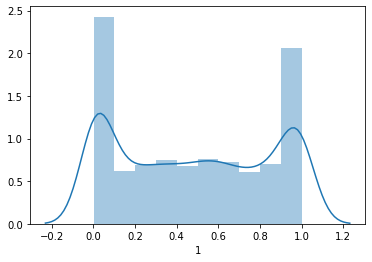

In [33]:
sns.distplot(nn_pred_sub)